# Kigali shape: parameters and bore geometry

The **Kigali shape** (`KigaliShape` in DidgeLab) is a parametric didgeridoo bore model. It builds a bore from:

1. **Base taper** – A power-law curve between mouthpiece and bell (length, bell diameter, exponent).
2. **Segment jitter** – Per-segment x/y offsets from the genome that give each bore a unique, organic profile.
3. **Optional forced diameters** – Exact diameter constraints at chosen positions (RBF interpolation).
4. **Bell accent** – Extra flare near the bell end.
5. **Bubbles** – Local sinusoidal bulges along the bore (for tuning resonances).

This notebook explains each constructor parameter and uses **bore plots** to show how they affect the geometry. Run from the `doc/examples` directory so that the `didgelab` package is on the path (or set `sys.path` accordingly).

In [1]:
import sys
from pathlib import Path
# Add repo src so 'didgelab' can be imported (run from doc/examples; repo root = parent.parent)
sys.path.insert(0, str(Path.cwd().parent.parent / "src"))

import numpy as np
import matplotlib.pyplot as plt
from didgelab import KigaliShape, plot_bore

## Baseline shape

We create a baseline Kigali shape with default parameters and fix its genome so that later we can change one parameter at a time and compare bores. The genome encodes length, bell size, power-law exponent, optional bubble positions/sizes, and per-segment x/y offsets.

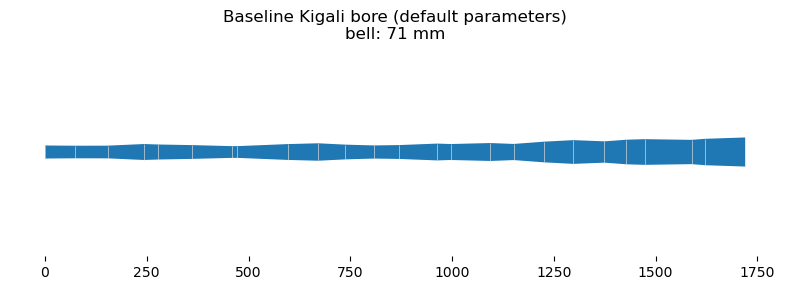

In [2]:
np.random.seed(0)
baseline = KigaliShape(n_segments=24, n_bubbles=0)
baseline_geo = baseline.genome2geo()

def bell_diameter_mm(geo):
    """Return bell diameter (mm) from a Geo: diameter at the bore end (max x)."""
    if not geo.geo:
        return 0
    return max(geo.geo, key=lambda p: p[0])[1]

def compare_bores(geo1, geo2, title1="Shape 1", title2="Shape 2", figsize=(10, 3)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    plot_bore(geo1, ax=ax1)
    d1 = bell_diameter_mm(geo1)
    ax1.set_title(f"{title1}\nbell: {d1:.0f} mm")
    plot_bore(geo2, ax=ax2)
    d2 = bell_diameter_mm(geo2)
    ax2.set_title(f"{title2}\nbell: {d2:.0f} mm")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(8, 3))
plot_bore(baseline_geo)
plt.title(f"Baseline Kigali bore (default parameters)\nbell: {bell_diameter_mm(baseline_geo):.0f} mm")
plt.tight_layout()
plt.show()

### `n_segments`

Number of bore segments (excluding endpoints) used for the base taper. More segments allow finer “jitter” variation along the bore; fewer segments give a smoother base with less resolution for genome-driven offsets.

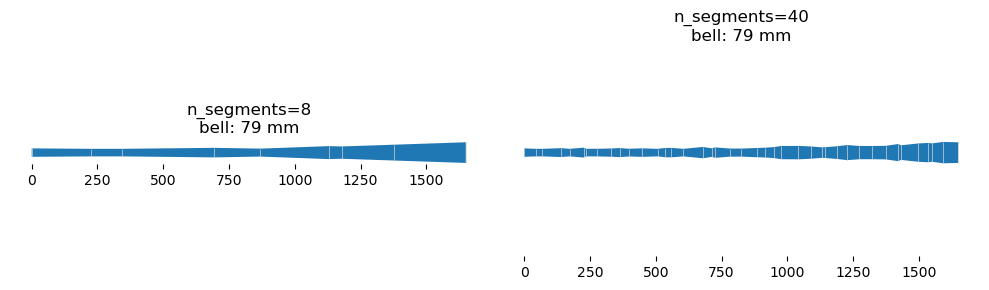

In [3]:
np.random.seed(42)
low_seg = KigaliShape(n_segments=8, n_bubbles=0)
np.random.seed(42)
high_seg = KigaliShape(n_segments=40, n_bubbles=0)
compare_bores(low_seg.genome2geo(), high_seg.genome2geo(),
              title1="n_segments=8", title2="n_segments=40")

### `d0` (mouthpiece diameter)

Mouthpiece (input) diameter in mm. The bore starts at this diameter at the playing end.

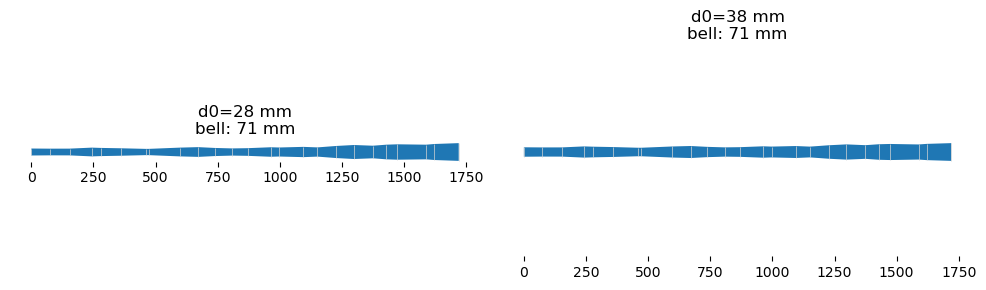

In [4]:
# Same genome, different d0
s1 = KigaliShape(n_segments=24, n_bubbles=0, d0=28)
s2 = KigaliShape(n_segments=24, n_bubbles=0, d0=38)
s1.genome = np.copy(baseline.genome)
s2.genome = np.copy(baseline.genome)
compare_bores(s1.genome2geo(), s2.genome2geo(), title1="d0=28 mm", title2="d0=38 mm")

### `d_bell_min` and `d_bell_max`

The bell diameter is chosen from the genome in the range `[d_bell_min, d_bell_max]` (mm). Gene 1 maps [0,1] to this range. These bounds set how small or large the bell can be.

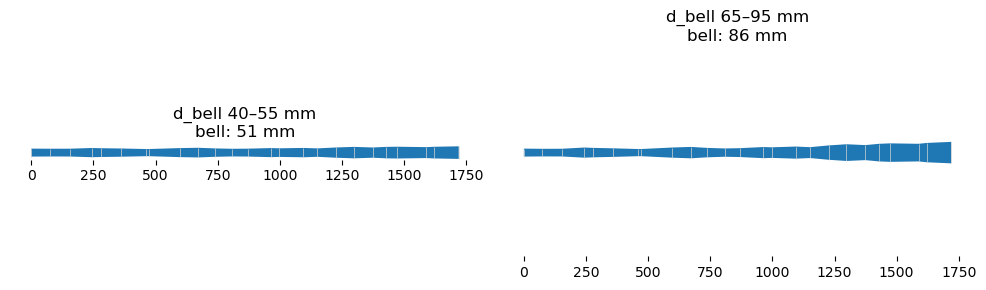

In [5]:
# Same genome (same bell gene), different bell bounds
s_small = KigaliShape(n_segments=24, n_bubbles=0, d_bell_min=40, d_bell_max=55)
s_large = KigaliShape(n_segments=24, n_bubbles=0, d_bell_min=65, d_bell_max=95)
s_small.genome = np.copy(baseline.genome)
s_large.genome = np.copy(baseline.genome)
compare_bores(s_small.genome2geo(), s_large.genome2geo(),
              title1="d_bell 40–55 mm", title2="d_bell 65–95 mm")

### `min_length` and `max_length`

Bore length in mm. The genome’s first gene maps [0,1] to `[min_length, max_length]`, so these parameters set the allowed length range of the instrument.

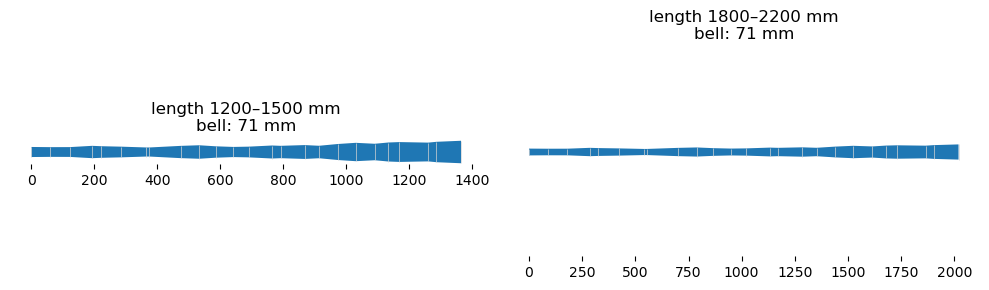

In [6]:
# Same genome, different length range
s_short = KigaliShape(n_segments=24, n_bubbles=0, min_length=1200, max_length=1500)
s_long  = KigaliShape(n_segments=24, n_bubbles=0, min_length=1800, max_length=2200)
s_short.genome = np.copy(baseline.genome)
s_long.genome = np.copy(baseline.genome)
compare_bores(s_short.genome2geo(), s_long.genome2geo(),
              title1="length 1200–1500 mm", title2="length 1800–2200 mm")

### `n_bubbles`

Number of optional “bubbles” (sinusoidal bulges) along the bore. Each bubble adds a local expansion; position, width, and height are encoded in the genome. Bubbles are often used to tune specific resonances (e.g. toots) without changing the overall taper.

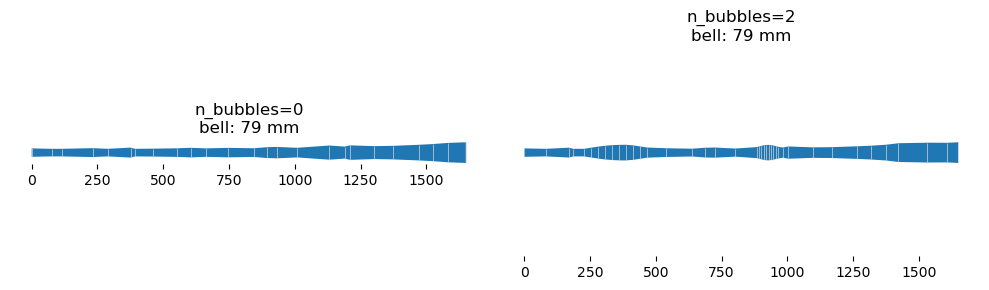

In [7]:
np.random.seed(42)
no_bub = KigaliShape(n_segments=24, n_bubbles=0)
np.random.seed(42)
two_bub = KigaliShape(n_segments=24, n_bubbles=2)
compare_bores(no_bub.genome2geo(), two_bub.genome2geo(),
              title1="n_bubbles=0", title2="n_bubbles=2")

### `smoothness`

Fraction in [0,1] that scales how much the genome’s segment y-offsets affect the bore. Higher values reduce the amplitude of these offsets (smoother bore); lower values allow more “jitter” and variation.

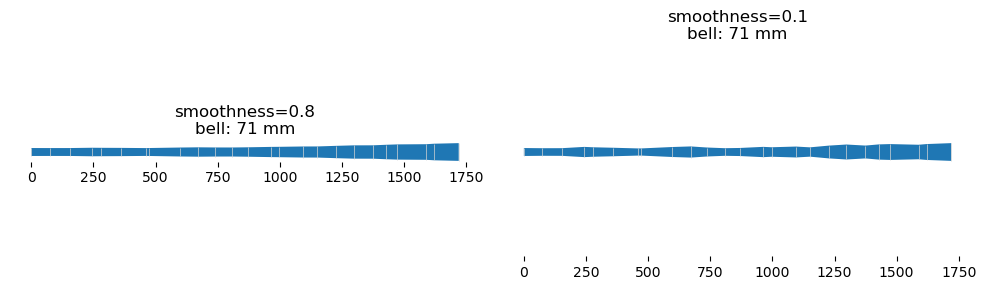

In [8]:
# Use same n_segments/n_bubbles as baseline so genome length matches when copying
s_smooth = KigaliShape(n_segments=24, n_bubbles=0, smoothness=0.8)
s_rough  = KigaliShape(n_segments=24, n_bubbles=0, smoothness=0.1)
s_smooth.genome = np.copy(baseline.genome)
s_rough.genome = np.copy(baseline.genome)
compare_bores(s_smooth.genome2geo(), s_rough.genome2geo(),
              title1="smoothness=0.8", title2="smoothness=0.1")

### `bell_accent` and `bell_start`

- **bell_accent**: If > 0, the last part of the bore is accentuated (flared) by this factor, increasing volume and projection.
- **bell_start**: Length in mm from the bell end over which the bell accent is applied. Only the final `bell_start` mm are modified.

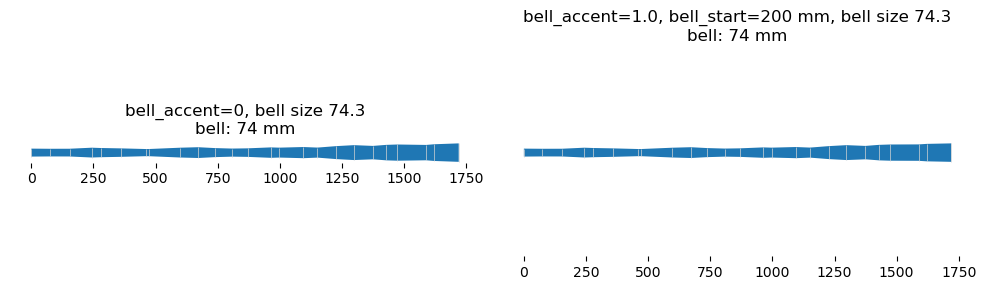

In [9]:
# No accent vs strong accent over last 200 mm
s_no_accent = KigaliShape(n_segments=24, n_bubbles=0, bell_accent=0.0, bell_start=200, d_bell_min=60, d_bell_max=80)
s_accent   = KigaliShape(n_segments=24, n_bubbles=0, bell_accent=1.0, bell_start=200, d_bell_min=60, d_bell_max=80)
s_no_accent.genome = np.copy(baseline.genome)
s_accent.genome = np.copy(baseline.genome)
compare_bores(s_no_accent.genome2geo(), s_accent.genome2geo(),
              title1=f"bell_accent=0, bell size {s_no_accent.genome2geo().geo[-1][1]:.1f}", title2=f"bell_accent=1.0, bell_start=200 mm, bell size {s_accent.genome2geo().geo[-1][1]:.1f}")

### `forced_diameters`

A list of `[[x_pos_mm, diameter_mm], ...]` that force the bore to pass through exact diameters at specific distances from the mouthpiece. The implementation uses RBF (radial basis function) interpolation so the bore is smoothly warped to meet these constraints while keeping the ends fixed. Useful for matching measured geometries or design targets.

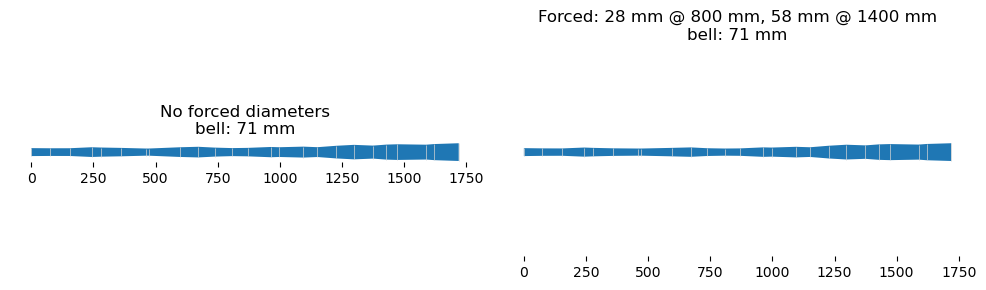

In [10]:
# No forcing vs two forced points (narrower at 800 mm, wider at 1400 mm)
s_free = KigaliShape(n_segments=24, n_bubbles=0)
s_free.genome = np.copy(baseline.genome)
s_forced = KigaliShape(n_segments=24, n_bubbles=0,
                       forced_diameters=[[800, 28], [1400, 58]])
s_forced.genome = np.copy(baseline.genome)
compare_bores(s_free.genome2geo(), s_forced.genome2geo(),
              title1="No forced diameters", title2="Forced: 28 mm @ 800 mm, 58 mm @ 1400 mm")

## Summary

| Parameter | Meaning |
|-----------|--------|
| `n_segments` | Number of segments for the base taper (more = finer jitter). |
| `d0` | Mouthpiece diameter (mm). |
| `d_bell_min`, `d_bell_max` | Bell diameter range (mm); genome maps [0,1] into this range. |
| `min_length`, `max_length` | Bore length range (mm); genome maps [0,1] into this range. |
| `n_bubbles` | Number of sinusoidal bulges along the bore (position/width/height in genome). |
| `smoothness` | Scale for segment y-offsets (higher = smoother bore). |
| `bell_accent` | Extra flare factor on the last part of the bore (> 0 to enable). |
| `bell_start` | Length (mm) from bell end over which `bell_accent` is applied. |
| `n_bell_segments` | Number of points used to build the accentuated bell curve (internal). |
| `forced_diameters` | List of `[x_mm, diameter_mm]` for exact diameter constraints (RBF interpolation). |

For full details and the genome layout, see `KigaliShape` in `didgelab.shapes.KigaliShape`.